### <div class="label label-info">CLAUDIO SCALZO</div>
# ASI Challenge Exercise
### Naive Bayes Classification and Bayesian Linear Regression on the <tt>Fashion-MNIST</tt> and <tt>CIFAR-10</tt> datasets

<div class='alert alert-info'>
<div class='label label-info'>INSTRUCTIONS TO RUN THE NOTEBOOK</div>
<br>
To be able to run the notebook the only thing to ensure is that the datasets are in the correct directories. The following structure is the correct one:
<code>
- asi_challenge_claudio_scalzo.ipynb
- datasets/
    - Fashion-MNIST/
        - fashion-mnist_train.csv
        - fashion-mnist_test.csv
    - CIFAR-10/
        - data_batch_1
        - data_batch_2
        - data_batch_3
        - data_batch_4
        - data_batch_5
        - test_batch
</code>
<br>
<div class='label label-info'>COLORS</div>
<br>
For the sake of readability, the notebook will follow a color convention:
<br>
<ul>
    <li>All the cells related to the <tt>Fashion-MNIST</tt> dataset will be in green and labeled with: <div class="label label-success">FASHION-MNIST</div></li>
    <li>All the cells related to the <tt>CIFAR-10</tt> dataset will be in yellow and labeled with: <div class="label label-warning">CIFAR-10</div></li>
    <li>All the blue cells are generic comments and the answers to the exercise questions are marked with: <div class="label label-danger">ANSWER</div></li>
</ul>
<br>
<div class='label label-info'>SECTIONS</div>
<br>
The sections numbering will follow exactly the one provided in the requirements PDF.
</div>

In [1]:
### LIBRARIES IMPORT

# Data structures
import numpy as np
import pandas as pd
from numpy.linalg import inv, solve

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

# Utilities
import math as math
from time import time, sleep
import pickle
import itertools

# Distrubutions
from scipy.stats import skew, probplot, multivariate_normal

# Error
from sklearn.metrics import explained_variance_score, mean_squared_error, confusion_matrix

# 1. Datasets loading

<div class='alert alert-info'>
The first step consists in the datasets import. This process will be split in two parts, one for the <tt>Fashion-MNIST</tt> dataset and another one for the <tt>CIFAR-10</tt> dataset. While in the first case it will be very easy (being the dataset saved in <b>csv</b> files), in the seconds case the process will be longer, because the CIFAR datasets are saved in <b>binary</b> files.
</div>

### <div class="label label-success">FASHION-MNIST</div>

<div class='alert alert-success'>
Let's define the datasets location and load them in two Pandas DataFrame: <tt>mnistTrain</tt> and <tt>mnistTest</tt>.
</div>

In [2]:
# DIRECTORY AND CONSTANTS DEFINITION
mnistPath = "./datasets/Fashion-MNIST/"
height = 28
width = 28

# FILEPATHS DEFINITION
mnistTrainFile = mnistPath + "fashion-mnist_train.csv"
mnistTestFile = mnistPath + "fashion-mnist_test.csv"

# LOAD THE MNIST AND CIFAR TRAINSET AND DATASET
mnistTrain = pd.read_csv(mnistTrainFile)
mnistTest = pd.read_csv(mnistTestFile)

<div class='alert alert-success'>
Now we can show some example of the loaded data:
</div>

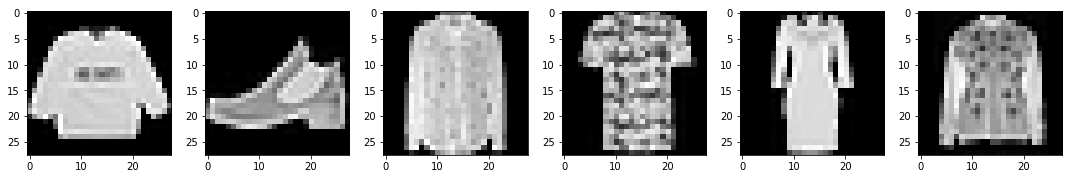

In [3]:
# SHOW SOME SAMPLES
plt.figure(figsize=(15,10))
for i in range(6):
    plt.subplot(1,6,i+1)
    image = mnistTrain.drop(columns=["label"]).loc[i].values.reshape((height, width))
    plt.imshow(image, cmap="gray")
plt.tight_layout()
plt.show()

### <div class="label label-warning">CIFAR-10</div>

<div class='alert alert-warning'>
First of all, we have to declare the path of the <tt>CIFAR-10</tt> datasets and some useful values:
</div>

In [4]:
# DIRECTORY AND CONSTANTS DEFINITION
cifarPath = "./datasets/CIFAR-10/"
trainfiles = 5
height = 32
width = 32
channels = 3
pixels = height * width * channels
chpix = height * width

<div class='alert alert-warning'>
Now, let's define a function to load a single binary file which contains a certain number of images:
</div>

In [5]:
# FUNCTION TO LOAD A SINGLE TRAINFILE
def loadImages(filename, height, width, channels):
    
    # Load binary file
    file = open(filename, "rb")
    
    # Unpickle
    data = pickle.load(file, encoding="bytes")
    
    # Get raw images and raw classes
    rawImages = data[b'data']
    rawClasses = data[b'labels']
    
    return np.array(rawImages, dtype=int), np.array(rawClasses, dtype=int)

<div class='alert alert-warning'>
Now it's time to use the previous function to load all the five <b>trainsets</b> in our directory: they will be merged in a unique Pandas DataFrame named <tt>cifarTrain</tt>.
</div>

In [6]:
# ALLOCATE AN EMPTY ARRAY (width of number of pixels + one for the class label)
images = np.empty(shape=(0, pixels + 1), dtype=int)

# LOAD ALL THE TRAINFILES
for i in range(trainfiles):
    
    # Load the images and classes for the "i"th trainfile
    newImages, newClasses = loadImages(filename = cifarPath + "data_batch_" + str(i + 1),
                                       height = height,
                                       width = width,
                                       channels = channels)
    
    # Create the new batch (concatenating images and classes)
    newBatch = np.concatenate((np.asmatrix(newClasses).T, newImages), axis=1)
    
    # Concatenate the new batch with the previous ones
    images = np.concatenate((images, newBatch), axis=0)

# CREATE THE TRAIN DATAFRAME
attributes = [("pixel" + str(i) + "_" + str(c)) for c in ["r", "g", "b"] for i in range(height * width)]
cifarTrain = pd.DataFrame(images, columns = ["label"] + attributes)

<div class='alert alert-warning'>
The <tt>cifarTrain</tt> has been imported, now let's do the same for the file containing the <b>testset</b>: also in this case, it will be saved in a dataframe, <tt>cifarTest</tt>.
</div>

In [7]:
# LOAD THE IMAGES AND CLASSES
newImages, newClasses = loadImages(filename = cifarPath + "test_batch",
                                   height = height,
                                   width = width,
                                   channels = channels)

# CREATE THE IMAGES ARRAY (concatenating images and classes)
images = np.concatenate((np.asmatrix(newClasses).T, newImages), axis=1)

# CREATE THE TEST DATAFRAME
attributes = [("pixel" + str(i) + "_" + str(c)) for i in range(height * width) for c in ["r", "g", "b"]]
cifarTest = pd.DataFrame(images, columns = ["label"] + attributes)

<div class='alert alert-warning'>
Now we can show some example of the loaded data:
</div>

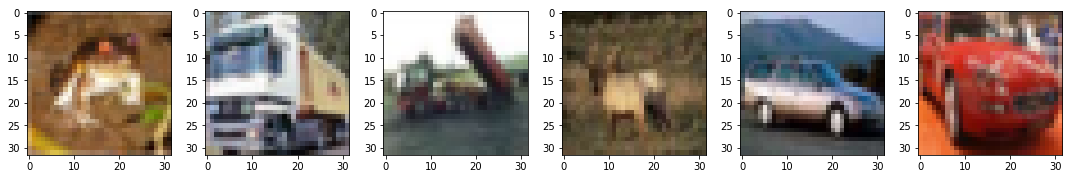

In [8]:
# SHOW SOME SAMPLES
plt.figure(figsize=(15,10))
for i in range(0,6):
    plt.subplot(1,6,i+1)
    imageR = cifarTrain.iloc[i, 1 : chpix+1].values.reshape((height,width))
    imageG = cifarTrain.iloc[i, chpix+1 : 2*chpix+1].values.reshape((height,width))
    imageB = cifarTrain.iloc[i, 2*chpix+1 : 3*chpix+1].values.reshape((height,width))
    image = np.dstack((imageR, imageG, imageB))
    plt.imshow(image)
plt.tight_layout()
plt.show()

<div class='alert alert-info'>
Everything is loaded! We can start analyzing our data.
</div>

# 2. Descriptive statistics

### 2.1 Data description

<div class='alert alert-info'>
The first step is to investigate data. It is a fundamental section, where we will learn about our data. Initially we show and plot really simple statistics: they are useful to introduce us, to understand what we are dealing with.
</div>

### <div class="label label-success">FASHION-MNIST</div>

In [9]:
# PRINT TO DESCRIBE THE TRAIN AND THE TEST
print("[TRAINSET]")
print("Number of rows:", mnistTrain.shape[0])
print("Attributes:", mnistTrain.drop(columns=['label']).shape[1], "(without considering the label)")

print("\n[TESTSET]")
print("Number of rows:", mnistTest.shape[0])
print("Attributes:", mnistTest.drop(columns=['label']).shape[1], "(without considering the label)")

print("\nExample:")
display(mnistTrain.head(5))

[TRAINSET]
Number of rows: 60000
Attributes: 784 (without considering the label)

[TESTSET]
Number of rows: 10000
Attributes: 784 (without considering the label)

Example:


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<div class='alert alert-success'>
The number of rows is <b>60000</b>, while the number of columns is <b>785</b> (784 attributes + 1 label). But what does they mean?<br>
<br>
<list>
    <li>Each <b>row</b> represents a picture.</li>
    <li>Each <b>column</b> represents a pixel.</li>
    <li>So, the <b>value</b> of a row <i>"r"</i> in a given column <i>"c"</i> represents the brightness (from 0 to 255) of a given pixel <i>"c"</i> in a given picture <i>"r"</i>.</li>
</list><br>
In the testset we find the same situation but with a smaller row dimension: <b>10000</b>. The number of columns is, of course, the same: <b>785</b> (784 attributes + 1 label).<br>
</div>

### <div class="label label-warning">CIFAR-10</div>

In [10]:
# PRINT TO DESCRIBE THE TRAIN
print("[TRAINSET]")
print("Number of rows:", cifarTrain.shape[0])
print("Attributes:", cifarTrain.drop(columns=['label']).shape[1], "(without considering the label)")

print("\n[TESTSET]")
print("Number of rows:", cifarTest.shape[0])
print("Attributes:", cifarTest.drop(columns=['label']).shape[1], "(without considering the label)")

print("\nExample:")
display(cifarTrain.head(5))

[TRAINSET]
Number of rows: 50000
Attributes: 3072 (without considering the label)

[TESTSET]
Number of rows: 10000
Attributes: 3072 (without considering the label)

Example:


,label,pixel0_r,pixel1_r,pixel2_r,pixel3_r,pixel4_r,pixel5_r,pixel6_r,pixel7_r,pixel8_r,...,pixel1014_b,pixel1015_b,pixel1016_b,pixel1017_b,pixel1018_b,pixel1019_b,pixel1020_b,pixel1021_b,pixel1022_b,pixel1023_b
0,6,59,43,50,68,98,119,139,145,149,...,59,58,65,59,46,57,104,140,84,72
1,9,154,126,105,102,125,155,172,180,142,...,22,42,67,101,122,133,136,139,142,144
2,9,255,253,253,253,253,253,253,253,253,...,78,83,80,69,66,72,79,83,83,84
3,4,28,37,38,42,44,40,40,24,32,...,53,39,59,42,44,48,38,28,37,46
4,1,170,168,177,183,181,177,181,184,189,...,92,88,85,82,83,79,78,82,78,80


<div class='alert alert-warning'>
The number of rows is <b>50000</b>, because we merged 5 files of 10000 rows (images) each. The number of columns is instead <b>3073</b> (3072 attributes + the label): why this number? Because each picture was a 32x32 pixels, with 3 channels (RGB), so each picture has 3072 pixels.<br>
<br>
The number of rows in the testset is smaller: <b>10000</b>.<br>
</div>

### 2.2 Data distribution analysis

<div class='alert alert-info'>
Now is time to analyze the distribution of our data. In this section I'm going to analyze the distribution of <b>both</b> the trainset and the testset, so I'll create the <tt>all</tt> variables.
</div>

In [11]:
# CREATE THE 'ALL' DATAFRAMES
mnistAll = pd.concat((mnistTrain, mnistTest)).reset_index(drop=True)
cifarAll = pd.concat((cifarTrain, cifarTest)).reset_index(drop=True)

### <div class="label label-success">FASHION-MNIST</div> <div class="label label-warning">CIFAR-10</div>

In [12]:
# TAKE DISTRIBUTION
mnistDistribution = mnistAll["label"].value_counts()
cifarDistribution = cifarAll["label"].value_counts()

# TAKE CLASSES AND FREQUENCIES
mnistClasses = np.array(mnistDistribution.index)
mnistFrequencies = np.array(mnistDistribution.values)

cifarClasses = np.array(cifarDistribution.index)
cifarFrequencies = np.array(cifarDistribution.values)

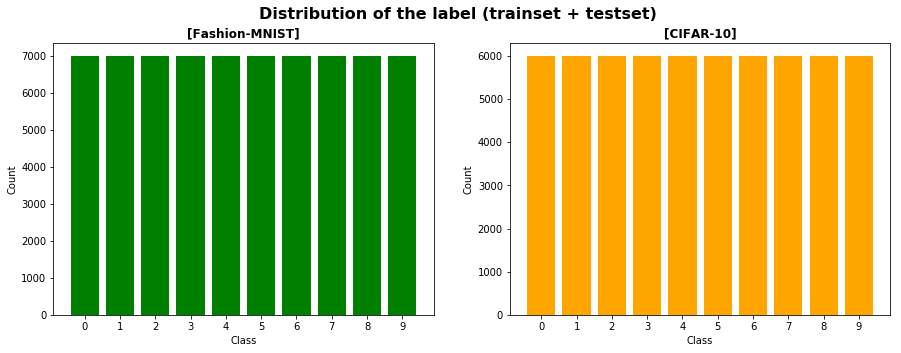

In [13]:
# PLOT THE DISTRIBUTION OF THE TARGET VARIABLE
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.bar(mnistClasses, mnistFrequencies, align="center", color="green")
plt.xticks(list(range(np.min(mnistClasses), np.max(mnistClasses)+1)))
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("[Fashion-MNIST]", weight="semibold");

plt.subplot(1,2,2)
plt.bar(cifarClasses, cifarFrequencies, align="center", color="orange")
plt.xticks(list(range(np.min(mnistClasses), np.max(mnistClasses)+1)))
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("[CIFAR-10]", weight="semibold");

plt.suptitle("Distribution of the label (trainset + testset)", fontsize=16, weight="bold")
plt.show()

<div class='alert alert-info'>
<div class='label label-danger'>QUESTION</div><br>
<i><b>Comment on the distribution of class labels and the dimensionality of the input and how these may affect the analysis.</b></i><br>
<br>
<div class='label label-danger'>ANSWER</div><br>
<b>- The dimensionality</b><br>
First of all, the dimensionality is very high. As previously said, each column represents a pixel of the image! So, even a very small picture has a lot of features. A big dimensionality like this (784 attributes on the <tt>Fashion-MNIST</tt> and 3072 attributes on the <tt>CIFAR-10</tt>) can represent an issue for the predictive model, generally known as "curse of dimensionality" (<a href="https://en.wikipedia.org/wiki/Curse_of_dimensionality">source</a>).<br>
Applying a model with a dataset with so many distributions can be problematic, and some strategies of dimensionality reductions can be used in this case. Talking about the number of rows: it can be an advantage to train the model with a lot of data, but of course overfitting issues have to be avoided. In this case we have a relatively big number of rows: the training and test times can be problematic, especially when big matricial computations have to be done to predict the class label.<br>
<br>
In our case, the high dimensionality is an issue for both the classifier and the regressor.
The Naive Bayes Classifier, indeed, has to infer the class label given a lot of attributes and has to compute a lot of likelihoods to infer the posterior probability. The Bayesian Linear Regression algorithm, instead, has to find the weights (and find the regression line) basing its analysis on a big set of dimensions, which is of course harder (and computationally heavier because of the big matrices in the products).<br>
<br>
<b>- The distribution</b><br>
The distribution is <b>uniform</b>: each class has the same amount of images in the dataset.<br>
</div>

<div class='alert alert-info'>
Before starting the new section, let's define the function to graphically plot the confusion matrix. This function will be useful to show the classifier and the regressor performance in the two datasets.
</div>

In [14]:
def plotConfusionMatrix(cm, classes, normalize = False, title = "Confusion matrix", cmap = plt.cm.Greens):

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

<div class='alert alert-info'>
Moreover, to facilitate each model's work, we can normalize the values of our datasets (except for the class label) dividing each value by 255. Let's do it:
</div>

In [15]:
def normalize(dataset):
    return dataset.apply(lambda col: col.divide(255) if(col.name != "label") else col)

# NORMALIZE MNIST
mnistTrainNorm = normalize(mnistTrain)
mnistTestNorm = normalize(mnistTest)

# NORMALIZE CIFAR
cifarTrainNorm = normalize(cifarTrain)
cifarTestNorm = normalize(cifarTest)

# PRINT AN EXAMPLE
display(mnistTrainNorm.head(5))

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,9,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,6,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.019608,0.0,...,0.000000,0.0,0.0,0.117647,0.168627,0.000000,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.003922,0.007843,0.0,0.0,0.000000,0.0,...,0.011765,0.0,0.0,0.000000,0.000000,0.003922,0.0,0.0,0.0,0.0
4,3,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


<div class='alert alert-info'>
Now we're ready to start the classification.
</div>

# 3. Classification

### 3.a Naive Bayes Classifier

<div class='alert alert-info'>
Naive Bayes Classifier explanation here...
</div>

In [16]:
class NaiveBayesClassifier:
    
    # ----- PRIVATE METHODS ------------------------------------------------- #
    # MEANS AND VARIANCES FOR THE LIKELIHOOD: P(X|C)
    def _computeMeansCov(self, train):
        
        # Compute means and variances. For example:
        #    <means> |  attr0 | attr1 | ...    #  <vars> |  attr0 | attr1 | ...
        #    --------------------------        # --------------------------    
        #    class0  |   12   |   3   | ...    # class0  |   0.2  |  0.03 | ...
        #    class1  |   8    |   0   | ...    # class1  |  0.07  |  0.1  | ...
        #      ...   |  ...   |  ...  | ...    #   ...   |  ...   |  ...  | ...
        self.means = train.groupby("label").mean()
        self.cov = train.groupby("label").var()
    
    
    # PRIORS: P(C)
    def _computePriors(self, train):
        
        # Compute the distribution of the label
        frequencies = train["label"].value_counts().to_dict()
        
        # Set a probability for each class: an array of all P(Ci)
        self.priors = np.array([v / train.shape[0] for v in frequencies.values()])
    
    
    # LIKELIHOOD: P(X|C)
    def _logLikelihood(self, data, c):
        
        # Compute the P(X|Ci)
        likelihoodC = multivariate_normal.logpdf(data, self.means.loc[c], self.cov.loc[c] + 1e-3)
        
        # Sum it to the likelihoods accumulator (useful for the quality metric)
        self.likelihoods[c] += np.sum(likelihoodC)
        
        # Use the logarithmic pdf of the Multivariate Gaussian
        return likelihoodC
    # ----------------------------------------------------------------------- # 
    
    
    # ----- PUBLIC METHODS -------------------------------------------------- #
    # TRAIN - LIKELIHOOD and PRIOR
    def fit(self, train):
        
        # Classes
        self.classes = list(sorted(train["label"].unique()))
        
        # Init the likelihoods array (useful for quality metric)
        self.likelihoods = np.empty(shape=(len(self.classes)), dtype=int)
        
        # Compute priors and likelihoods
        self._computePriors(train)
        self._computeMeansCov(train)
        
        return self.classes
    
    
    # TEST - POSTERIOR: P(C|X)
    def predict(self, test):
        
        # The posterior array will be like:
        #     <post> | sample0 | sample1 | ...
        #    -----------------------------
        #    class0  |   0.1   |  0.4   | ...
        #    class1  |   0.18  |  0.35  | ...
        #      ...   |   ...   |  ...   | ... 
        self.posteriors = np.array([self._logLikelihood(test, c) + np.log(self.priors[c]) for c in self.classes])
        
        # Select the class with max probability for each sample
        return np.argmax(self.posteriors, axis=0)
    
    
    # VALIDATE PREDICTION
    def validate(self, pred, correct):
        
        # Accuracy, error, confusion matrix
        acc = np.mean(pred == correct)
        err = np.mean(pred != correct)
        cm = confusion_matrix(correct, pred)
        
        return acc, err, cm, np.sum(self.likelihoods)
    # ----------------------------------------------------------------------- #

In [17]:
# CLASSIFY FUNCTION
def classify(train, test, correct, color):
    
    # NAIVE BAYES CLASSIFIER
    nbc = NaiveBayesClassifier()

    # TRAIN
    startTime = time()
    classes = nbc.fit(train)
    endTime = time()
    print("Train time: %.3f seconds" % (endTime-startTime))

    # TEST
    startTime = time()
    pred = nbc.predict(test)
    endTime = time()
    print("Test time: %.3f seconds\n" % (endTime-startTime))

    # VALIDATION
    accuracy, error, cm, ls = nbc.validate(pred, correct)
    print("Accuracy: %.2f%%   |   Error: %.2f%%" % (accuracy * 100, error * 100))
    print("Likelihoods sum: %d" % (ls))
    plotConfusionMatrix(cm, classes, title="[Naive Bayes Classification] Confusion Matrix", cmap = color)

### <div class="label label-success">FASHION-MNIST</div>

<div class='alert alert-success'>
Let's start the classification for the <tt>Fashion-MNIST</tt> dataset:
</div>

Train time: 2.306 seconds
Test time: 4.442 seconds

Accuracy: 66.95%   |   Error: 33.05%
Likelihoods sum: 1787004175


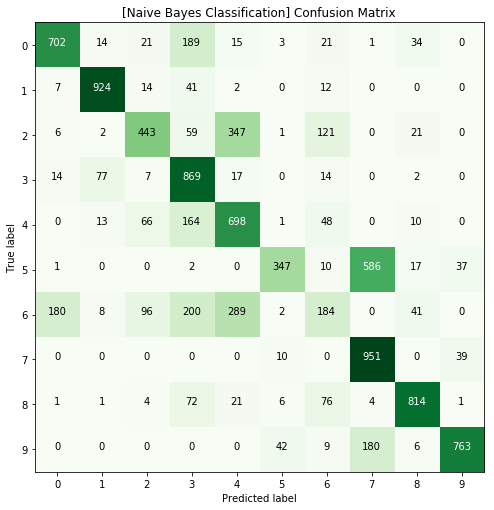

In [18]:
# CLASSIFY
classify(train = mnistTrainNorm,
         test = mnistTestNorm.drop(columns=['label']),
         correct = mnistTestNorm['label'],
         color = "Greens")

### <div class="label label-warning">CIFAR-10</div>

<div class='alert alert-warning'>
Now it's time for the <tt>CIFAR-10</tt> classification:
</div>

Train time: 7.507 seconds
Test time: 88.190 seconds

Accuracy: 29.59%   |   Error: 70.41%
Likelihoods sum: 1766357488


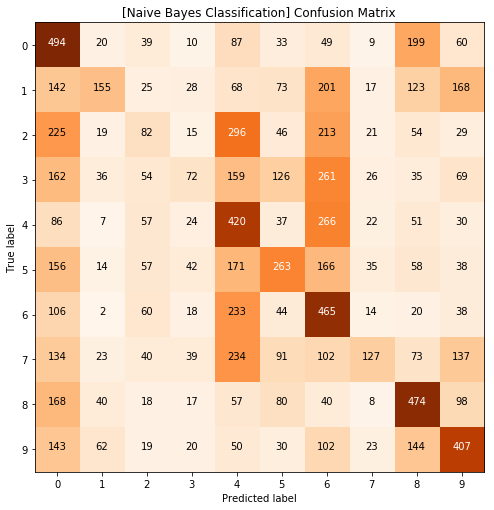

In [19]:
# CLASSIFY
classify(train = cifarTrainNorm,
         test = cifarTestNorm.drop(columns=['label']),
         correct = cifarTestNorm['label'],
         color = "Oranges")

# 4. Linear Regression

<div class='alert alert-info'>
Bayesian Linear Regression explanation here...
</div>

In [48]:
class BayesianLinearRegression:
    
    # ----- PRIVATE METHODS ------------------------------------------------- #
    # CREATE THE MATRIX FOR THE MATRICIAL-FORM REGRESSION
    # -> The shape will be:
    #    1   x1^1   x1^2   ...
    #    1   x2^1   x2^2   ...
    #    1   x3^2   x3^2   ...
    #   ...   ...    ...   ...
    def _matricize(self, x, k):
        
        # ALLOCATE MATRIX
        X = np.ones(shape=(x.shape[0], 1), dtype=int)
        # X = np.ones(shape=(x.shape[0], x.shape[1]), dtype=int)

        # STACK COLUMNS
        for i in range(k):
            X = np.hstack((X, np.power(x, i+1))) 
            
        return X
    
    
    # COMPUTE THE WEIGHTS ARRAY
    def _weights(self, X, t):
        
        # Solve, when feasible, is faster so:
        #     inv(X.T.dot(X)).dot(X.T).dot(t)
        # becomes:
        return np.linalg.solve(X.T.dot(X), X.T.dot(t))
    
    
    # RETURN THE VARIANCE
    def _variance(self, X, w, t):
        
        return (t - X.dot(w.T)).T.dot(t - X.dot(w.T)) / X.shape[0]
    
    
    # RETURN THE PREDICTED t
    def _target(self, X_new, w):
        
        return X_new.dot(w.T)
    
    
    # RETURN THE PREDICTIVE VARIANCE
    def _predictiveVar(self, X_new, X, var):
        
        # ("+" instead of "*" for numerical reasons)
        return var + np.diag(X_new.dot(inv(X.T.dot(X))).dot(X_new.T))
    # ----------------------------------------------------------------------- #
    
    
    # ----- PUBLIC METHODS -------------------------------------------------- #
    # TRAIN
    def fit(self, train, k):
        
        # Split train in x and t
        self.t = train["label"]
        self.x = train.drop(columns=["label"])
        
        # Compute X, w and t
        self.X = self._matricize(self.x, k)
        self.w = self._weights(self.X, self.t)
        self.var = self._variance(self.X, self.w, self.t)
        
        return sorted(self.t.unique())
    
    
    # TEST
    def predict(self, test, k):
        
        # Compute the matrix for the test set
        X_new = self._matricize(test, k)
        
        # Predict the new target for the test set (as a continuous variable)
        t_new_raw = self._target(X_new, self.w)
        
        # Discretize predictions 
        discretizer = np.vectorize(lambda label: 9 if label > 9 else (0 if label < 0 else round(label)))
        t_new = np.array(discretizer(t_new_raw), dtype=int)
        
        # Compute the predictive variance
        var_new = self._predictiveVar(X_new, self.X, self.var)
        
        return t_new, var_new, t_new_raw
        
    
    # VALIDATION
    def validate(self, pred, correct, raw):
        
        # Accuracy, error, confusion matrix, mse
        acc = np.mean(pred == correct)
        err = np.mean(pred != correct)
        cm = confusion_matrix(correct, pred)
        mse = mean_squared_error(correct, raw)
        
        return acc, err, cm, mse
    # ----------------------------------------------------------------------- #

In [49]:
def regress(train, test, correct, k, color):
    
    # BAYESIAN LINEAR REGRESSION
    blr = BayesianLinearRegression()

    # TRAIN
    startTime = time()
    classes = blr.fit(train, k)
    endTime = time()
    print("Train time: %.3f seconds" % (endTime-startTime))

    # TEST
    startTime = time()
    pred, var, raw = blr.predict(test, k)
    endTime = time()
    print("Test time: %.3f seconds\n" % (endTime-startTime))

    # VALIDATION
    accuracy, error, cm, mse = blr.validate(pred, correct, raw)
    print("[RAW PREDICTIONS] Mean Squared Error (MSE): %.2f" % (mse))
    print("[DISCRETE PREDICTIONS] Accuracy: %.2f%%   |   Error: %.2f%%" % (accuracy * 100, error * 100))
    plotConfusionMatrix(cm, classes, title="[Bayesian Linear Regression] Confusion Matrix", cmap = color)
    plt.figure(figsize=(15,6))
    plt.title("Predicted variances on a subset of the predicted data", weight="semibold", fontsize=14)
    plt.errorbar(list(range(100)), pred[:100], var[:100], ls="None", color=color[:-1], marker=".", markerfacecolor="black")
    plt.show()

### <div class="label label-success">FASHION-MNIST</div>

Train time: 1.709 seconds
Test time: 4.331 seconds

[RAW PREDICTIONS] Mean Squared Error (MSE): 1.96
[DISCRETE PREDICTIONS] Accuracy: 39.19%   |   Error: 60.81%


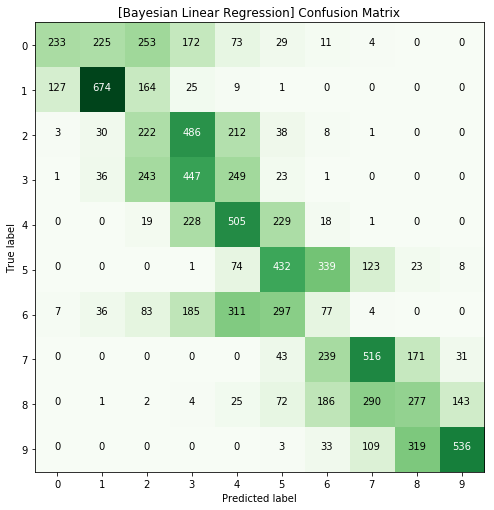

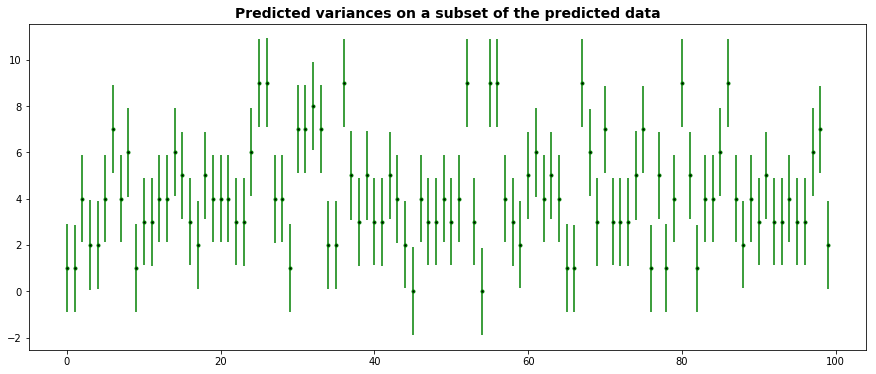

In [22]:
# REGRESS
regress(train = mnistTrainNorm,
        test = mnistTestNorm.drop(columns=['label']),
        correct = mnistTestNorm['label'],
        k = 1,
        color = "Greens")

### <div class="label label-warning">CIFAR-10</div>

Train time: 17.942 seconds
Test time: 29.462 seconds

[RAW PREDICTIONS] Mean Squared Error (MSE): 8.03
[DISCRETE PREDICTIONS] Accuracy: 10.95%   |   Error: 89.05%


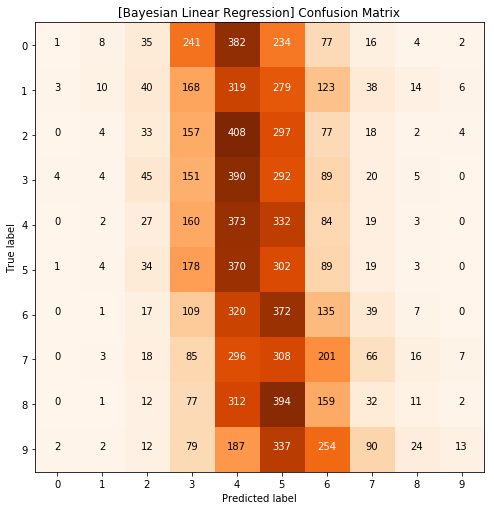

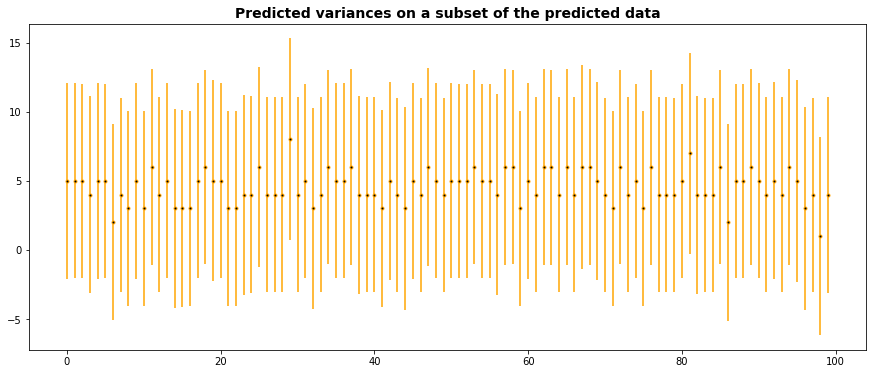

In [23]:
# REGRESS
regress(train = cifarTrainNorm,
        test = cifarTestNorm.drop(columns=['label']),
        correct = cifarTestNorm['label'],
        k = 1,
        color = "Oranges")

# 5. Bonus question

In [18]:
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [28]:
# PARAMETERS
num_classes = 10
input_shape = (28, 28, 1)
batch_size = 128
epochs = 4

# DATASETS RESHAPING
x_train = mnistTrainNorm.drop(columns=["label"]).loc[:49].values.reshape((50, 28, 28, 1)).astype('float32')
y_train_vec = to_categorical(mnistTrainNorm['label'].loc[:49].values.astype('float32'), num_classes)
y_train = mnistTrainNorm['label'].loc[:49].values

x_val = mnistTrainNorm.drop(columns=["label"]).loc[50:59].values.reshape((10, 28, 28, 1)).astype('float32')
y_val_vec = to_categorical(mnistTrainNorm['label'].loc[50:59].values.astype('float32'), num_classes)
y_val = mnistTrainNorm['label'].loc[50:59].values

x_test = mnistTestNorm.drop(columns=['label']).loc[:9].values.reshape((10, 28, 28, 1)).astype('float32')
y_test_vec = to_categorical(mnistTestNorm['label'].loc[:9].values.astype('float32'), num_classes)
y_test = mnistTestNorm['label'].loc[:9].values

In [29]:
# MODEL BUILDING
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten(name='flatten'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# MODEL COMPILING
model.compile(loss="categorical_crossentropy",
              optimizer="adadelta",
              metrics=['accuracy'])

# MODEL FITTING
model.fit(x_train, y_train_vec,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, y_val_vec))

# PREDICT
score = model.evaluate(x_test, y_test_vec, verbose=0)
print("[Score on the test set]")
print('Test loss: %.2f' % (score[0]))
print('Test accuracy: %.2f%%' % (score[1]))

Train on 50 samples, validate on 10 samples
Epoch 1/4
50/50 [==============================] - 1s 12ms/step - loss: 2.2998 - acc: 0.1800 - val_loss: 2.0617 - val_acc: 0.3000
Epoch 2/4
50/50 [==============================] - 0s 4ms/step - loss: 2.1625 - acc: 0.2200 - val_loss: 1.8959 - val_acc: 0.3000
Epoch 3/4
50/50 [==============================] - 0s 4ms/step - loss: 1.9851 - acc: 0.2800 - val_loss: 1.9445 - val_acc: 0.3000
Epoch 4/4
50/50 [==============================] - 0s 4ms/step - loss: 1.9029 - acc: 0.2400 - val_loss: 1.6769 - val_acc: 0.4000
[Score on the test set]
Test loss: 1.99%
Test accuracy: 0.30%


In [30]:
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer("flatten").output)
intermediate_train = intermediate_layer_model.predict(x_train)
intermediate_test = intermediate_layer_model.predict(x_test)
intermediate_train.shape

(50, 9216)

In [ ]:
pd1 = pd.DataFrame(intermediate_train)
pd1["label"] = pd.Series(y_train)

# CLASSIFY
classify(train = pd1,
         test = pd.DataFrame(intermediate_test),
         correct = y_test,
         color = "Oranges")

Train time: 0.032 seconds
